In [76]:
import os
import glob
import autogen
from autogen.graph_utils import visualize_speaker_transitions_dict
from autogen.agentchat.groupchat import GroupChat
from autogen.agentchat.contrib.retrieve_assistant_agent import RetrieveAssistantAgent
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent

In [96]:
config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

llm_config = {"config_list": config_list, "cache_seed": 1}

In [121]:
nurse = autogen.AssistantAgent(
    name="Nurse",
    llm_config=llm_config,
    system_message="""Nurse. You are a critical link between patients and the medical team. Your responsibilities include monitoring patient conditions, administering medications, and reporting vital signs to the Physicians.
    You assist in performing diagnostic tests and managing patient care logistics. Collect detailed patient information to update the Electronic Medical Records accurately and facilitate effective treatment planning by the Physicians.
    Respond to Physician directives by collecting specific patient data or performing necessary medical tasks. Communicate effectively with Patients to understand their concerns and symptoms, providing comfort and explaining treatment procedures.
    Reply `ADMINISTER TASK` when performing medical task on the patient.
    """
)

patient_2 = autogen.AssistantAgent(
    name="Patient2",
    llm_config=llm_config,
    system_message="""Patient. Communicate your symptoms, health history, and current concerns with Doctors and Nurses, understanding that your ability to articulate these may vary.
    Express how you feel about the treatments you receive and any difficulties you encounter in managing your health.
    React to inquiries from healthcare professionals based on your understanding and emotional state at the time. Engage with your care to different extents, depending on your personal health beliefs and experiences.
    """
)

physician_rag = RetrieveAssistantAgent(
    name="Doctor",
    human_input_mode="NEVER",
    llm_config=llm_config,
    # code_execution_config={
    #     # "work_dir": "coding",
    #     "use_docker": False,
    # },
    system_message="""
    You gather detailed health information through direct patient interactions, assessments from Nurses, and analysis of Electronic Medical Records. Based on this comprehensive data, develop and adjust treatment plans as necessary.
    When information is insufficient or symptoms are unclear, issue specific directives to Nurses to obtain further data, order additional diagnostic tests, or ask Patients for more detailed accounts of their symptoms.
    Engage in discussions with other healthcare professionals to coordinate care and ensure all aspects of the patient's health are addressed. Prioritize patient safety and treatment efficacy.
    In the healthcare setting, time can be of the essence so concision and clarity is key. However, show empathy towards patients.
    Reply `PERFORM EXAMINATION` when performing a medical examination on the patient.
    """,
    description="Doctor. You are responsible for diagnosing, treating, and overseeing the care of your patients."
)

emr_manager = RetrieveUserProxyAgent(
    name="EMR_Manager",
    human_input_mode="ALWAYS",
    max_consecutive_auto_reply=3,
    retrieve_config={
        "task": "qa",
        "docs_path": glob.glob("./emr_db/*"),
        "custom_text_types": ["non-existent-type"],
        "chunk_token_size": 2000,
        "model": config_list[0]["model"],
        "vector_db": "chroma",  # to use the deprecated `client` parameter, set to None and uncomment the line above
        "overwrite": True,  # set to True if you want to overwrite an existing collection
        "collection_name": "test",
    },
    # code_execution_config=False,
    code_execution_config={
        # "work_dir": "coding",
        "use_docker": False,
    },
    description="""EMR Agent. You store, manage, and retrieve patient health records. Receive updates from healthcare providers and log every interaction with timestamp and provider details.
    Provide medical history, test results, and other critical information upon request from authorized personnel only, ensuring compliance with privacy standards.
    """
)

data_synth = autogen.AssistantAgent(
    name="Data_Synthesizer",
    llm_config=llm_config,
    system_message="""Data Synthesizer. Upon request of an action or directive, like vital signs measuring or physical examination, you generate and return the results.
    You do not interact with other agents in the environment. Your response should be easy to input into electronic medical record.
    """
)
physician_rag.register_nested_chats(
    [{"recipient": data_synth, "max_turns": 1}],
    trigger=[nurse, physician_rag]
)

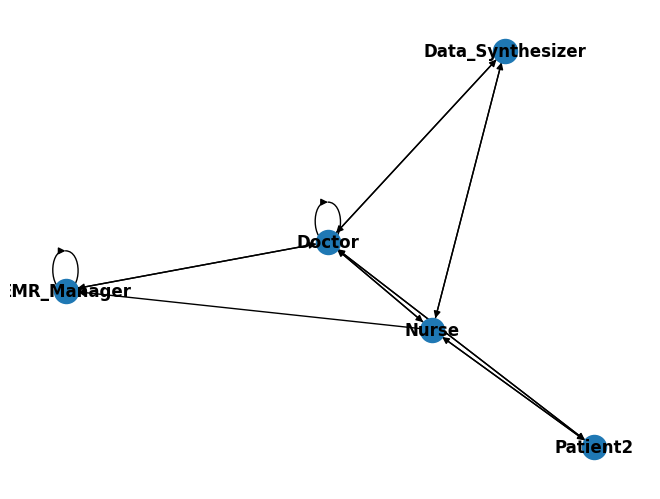

In [122]:
agents = [physician_rag, nurse, patient_2, emr_manager, data_synth]

allowed_speaker_transitions_dict = {
    patient_2:    [physician_rag, nurse],
    physician_rag:[physician_rag, nurse, patient_2, emr_manager, data_synth],
    nurse:        [physician_rag, patient_2, emr_manager, data_synth],
    emr_manager:  [physician_rag, emr_manager],
    data_synth:   [physician_rag, nurse],
}

visualize_speaker_transitions_dict(allowed_speaker_transitions_dict, agents)

In [123]:
from typing_extensions import Annotated

default_path = "emr_db/"

# @emr_manager.register_for_execution()
# @physician_rag.register_for_llm(description="Check the contents of a chosen file.")
# def see_file(patient: Annotated[str, "Patient's name."]):
#     print(os.getcwd())
#     with open(default_path + f"{patient}.txt", "r") as file:
#         lines = file.readlines()
#     formatted_lines = [f"{i+1}:{line}" for i, line in enumerate(lines)]
#     file_contents = "".join(formatted_lines)

#     return 0, file_contents

@emr_manager.register_for_execution()
@physician_rag.register_for_llm(description="List files in choosen directory.")
def list_dir(directory: Annotated[str, "Directory to check."] = "./"):
    files = os.listdir(default_path + directory)
    return 0, files

@emr_manager.register_for_execution()
@physician_rag.register_for_llm(description="Append new records in patient EMR.")
def modify_emr(
    patient: Annotated[str, "Patient's name."],
    new_info: Annotated[str, "New piece of information to append EMR with."],
):
    with open(default_path + f"{patient}.txt", "a") as file:
        file.write(new_info)
    return 0, "Patient's EMR modified"

@emr_manager.register_for_execution()
@physician_rag.register_for_llm(description="Create a new file with new patient information.")
def create_new_patient(
    patient: Annotated[str, "Patient's name."], info: Annotated[str, "Patient information to write in the file."]
):
    with open(default_path + f"{patient}.txt", "w") as file:
        file.write(info)
    return 0, "New Patient record created successfully"

# @emr_manager.register_for_execution()
# # @nurse.register_for_llm(name="update_emr", description="append patient's medical results into their EMR.")
# @physician_rag.register_for_llm(name="update_emr", description="append patient's medical results into their EMR.")
# def exec_update_emr(patient_name: str, info: str) -> str:
#     with open(f"./emr_db/{patient_name}.txt", 'a') as f:
#         f.write('\n\n')
#         f.write(info)

The return type of the function 'list_dir' is not annotated. Although annotating it is optional, the function should return either a string, a subclass of 'pydantic.BaseModel'.
The return type of the function 'modify_emr' is not annotated. Although annotating it is optional, the function should return either a string, a subclass of 'pydantic.BaseModel'.
The return type of the function 'create_new_patient' is not annotated. Although annotating it is optional, the function should return either a string, a subclass of 'pydantic.BaseModel'.


In [124]:
groupchat = GroupChat(
    agents=agents,
    messages=[],
    max_round=20,
    allowed_or_disallowed_speaker_transitions=allowed_speaker_transitions_dict,
    speaker_transitions_type="allowed",
    enable_clear_history=True,
)

manager = autogen.GroupChatManager(
    groupchat=groupchat,
    llm_config=llm_config,
    code_execution_config=False,
)

patient = "Patient3"
qa_problem = """List the directory. Retrieve the patient's medical record and ask them what brings them to the clinic.
                Perform at least one medical examination or test on the patient.
                Update their medical record if any meaningful results were collected.
            """

physician_rag.reset()
emr_manager.initiate_chat(
    manager,
    message=emr_manager.message_generator,
    problem=qa_problem,
    search_string=patient,
)

2024-04-30 17:49:07,722 - autogen.agentchat.contrib.retrieve_user_proxy_agent - INFO - Found 3 chunks.
2024-04-30 17:49:07,723 - autogen.agentchat.contrib.vectordb.chromadb - INFO - No content embedding is provided. Will use the VectorDB's embedding function to generate the content embedding.
Number of requested results 20 is greater than number of elements in index 3, updating n_results = 3


Trying to create collection.
VectorDB returns doc_ids:  [['f4201ef5']]
Adding content of doc f4201ef5 to context.
EMR_Manager (to chat_manager):

You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the
context provided by the user.
If you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.
You must give as short an answer as possible.

User's question is: List the directory. Retrieve the patient's medical record and ask them what brings them to the clinic.
                Perform at least one medical examination or test on the patient.
                Update their medical record if any meaningful results were collected.
            

Context is: Patient: Patient3
DOB: 11/05/1985

MRN (Medical Record Number): 1234567
Attending Physician:  Dr. Doctor

-----------Chief Complaint-----------

Persistent cough for the past 3 weeks
Shortness of breath with exertion
Occasional chest tightness
---

ChatResult(chat_id=None, chat_history=[{'content': "You're a retrieve augmented chatbot. You answer user's questions based on your own knowledge and the\ncontext provided by the user.\nIf you can't answer the question with or without the current context, you should reply exactly `UPDATE CONTEXT`.\nYou must give as short an answer as possible.\n\nUser's question is: List the directory. Retrieve the patient's medical record and ask them what brings them to the clinic.\n                Perform at least one medical examination or test on the patient.\n                Update their medical record if any meaningful results were collected.\n            \n\nContext is: Patient: Patient3\nDOB: 11/05/1985\n\nMRN (Medical Record Number): 1234567\nAttending Physician:  Dr. Doctor\n\n-----------Chief Complaint-----------\n\nPersistent cough for the past 3 weeks\nShortness of breath with exertion\nOccasional chest tightness\n-----------Vitals (Today's Visit)-----------\n\nDate: 05/30/2024\nTime: 10:1